In [2]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

import sys
sys.path.append('../..')
from src.utils import make_performance_uncertainty_plot, cross_entropy
from notebook_utils import NN, load_data, log_softmax
import os

In [3]:
model = NN()
train_loader, test_data, test_labels = load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
best_val_loss = np.inf
patience = 0
temperatures = [0.5, 1, 2]
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_val = np.inf

for epoch_idx in range(10000):
    for data, target in tqdm(train_loader, position=0, desc=f'Epoch: {epoch_idx} | Current Validation Loss: {loss_val:.2f} | Progress', leave=False):
        
        data = data.to(model.device)
        target = target.to(model.device)
        
        outputs = model(data)
        losses = [torch.nn.functional.nll_loss(
            log_softmax(outputs[i], t=temperatures[i]), 
            target
        ) for i in range(len(outputs))]

        loss = sum(losses)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch_idx % 1 == 0:
        
        test_data = test_data.to(model.device)
        test_labels = test_labels.to(model.device)
        
        outputs_val = model(test_data)
        losses_val = [torch.nn.functional.nll_loss(
            log_softmax(outputs_val[i], t=temperatures[i]), 
            test_labels
        ) for i in range(len(outputs_val))]
    
        loss_val = sum(losses_val) 
        
            
        if loss_val.item() < best_val_loss:
            best_val_loss = loss_val.item()
            torch.save(model.state_dict(), 'tmp.pth')
        else:
            patience += 1
            
            if patience == 8:
                model.load_state_dict(torch.load('tmp.pth'))
                os.remove('tmp.pth')
                break
    

In [5]:
with torch.no_grad():
    out_conf, out, out_diff = model(test_data)

out_conf = out_conf.cpu()
out = out.cpu()
out_diff = out_diff.cpu()
test_labels = test_labels.cpu()

In [6]:
out_conf, out, out_diff = torch.softmax(out_conf, dim=-1).numpy(), torch.softmax(out, dim=-1).numpy(), torch.softmax(out_diff, dim=-1).numpy()

In [7]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

In [8]:
entropy(out_conf.T).mean(), entropy(out.T).mean(), entropy(out_diff.T).mean()

(0.4316684, 0.82010955, 1.4029886)

In [9]:
uncs = out_conf - out_diff

In [10]:
preds = out.argmax(-1)

In [11]:
M = uncs[range(len(uncs)), preds]


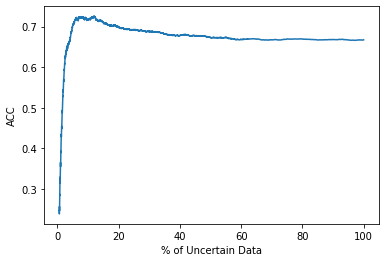

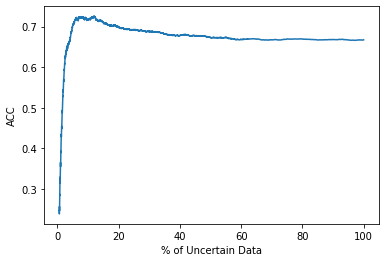

In [12]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, M, 'ACC', performance_fn=accuracy_score)

In [13]:
uncs = (entropy(out_diff.T) - entropy(out_conf.T))

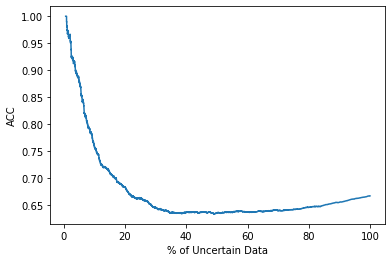

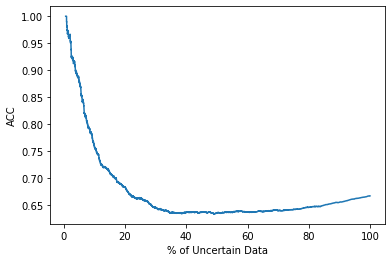

In [14]:

make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'ACC', performance_fn=accuracy_score)

In [15]:
cross_entropy(test_labels, out, n_labels=10)

array([0.36778265, 1.24157083, 0.44004393, ..., 0.0722412 , 4.97755289,
       0.07148678])

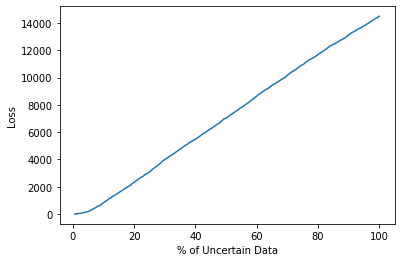

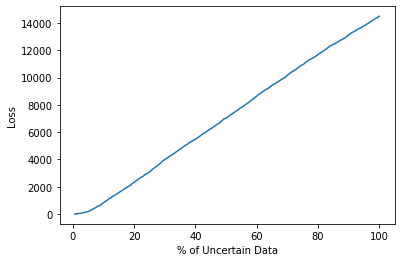

In [16]:
make_performance_uncertainty_plot(test_labels.numpy(), out, uncs, 'Loss', performance_fn_args={'reduction': 'sum', 'n_labels': 10})

In [17]:
uncs = entropy(out.T)

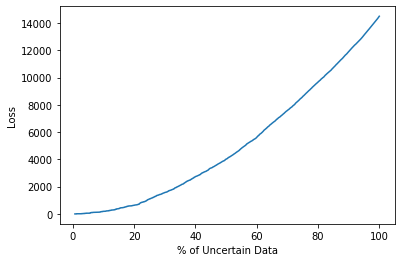

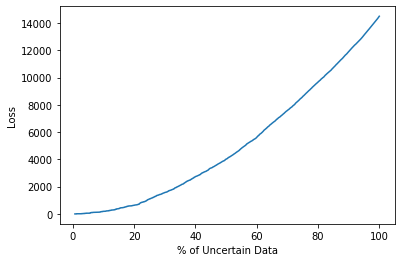

In [18]:
make_performance_uncertainty_plot(test_labels.numpy(), out, uncs, 'Loss', performance_fn_args={'reduction': 'sum',
                                                                                              'n_labels': 10})

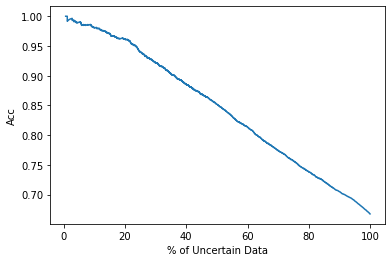

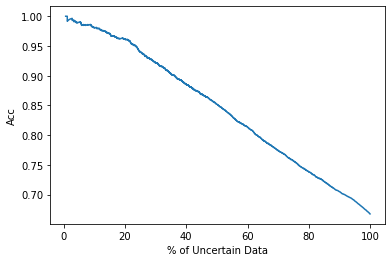

In [19]:
make_performance_uncertainty_plot(test_labels.numpy(), preds, uncs, 'Acc', performance_fn=accuracy_score)

In [5]:
import torch
torch.log2(torch.Tensor([0.5])).sum()

tensor(-1.)

In [14]:
torch.log2(torch.Tensor([0, 0.5, (.25)]))

tensor([-inf, -1., -2.])

In [20]:
torch.nn.functional.kl_div(torch.Tensor([.5, .25, .25]), torch.Tensor([1/3, 1/3, 1/3]))

tensor(-0.4773)

In [21]:
from scipy.special import kl_div


In [23]:
import numpy as np

In [32]:
p = np.array([1/3, 1/3, 1/3])

In [36]:
sum(kl_div(p, np.array([1/4, 1/3, 1/3])) * p)

0.0